In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass
print('data imported')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data imported


In [78]:
import os
import torch
import timm
import random
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchmetrics.classification import MulticlassF1Score, MulticlassStatScores
import concurrent.futures

In [72]:
torch.manual_seed(13)
np.random.seed(13)

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.image_paths = glob(f"{root}/*/*.jpg")
        self.classes = {}
        self.class_counts = {}
        count = 0
        
        for path in self.image_paths:
            class_name = path.split('/')[-2]
            if class_name not in self.classes:
                self.classes[class_name] = count
                self.class_counts[class_name] = 1
                count += 1
            else:
                self.class_counts[class_name] += 1
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.classes[image_path.split('/')[-2]]
        
        if self.transform:
            image = self.transform(image)
            
        return {'image': image, 'label': label}

In [73]:
class TransferLearningComparison:
    def __init__(self, root_dir, models, img_size=224, batch_size=32, num_epochs=10):
        self.root_dir = root_dir
        self.models = models
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize transforms
        self.transform = T.Compose([ 
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.setup_data()
        self.results = {model_name: {} for model_name in models.keys()}
        
    def setup_data(self):
        # Create dataset
        dataset = CustomDataset(self.root_dir, self.transform)
        
        # Split dataset
        total_size = len(dataset)
        train_size = int(0.7 * total_size)
        val_size = int(0.15 * total_size)
        test_size = total_size - train_size - val_size
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            dataset, [train_size, val_size, test_size]
        )
        
        # Create dataloaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size)
        
        self.num_classes = len(dataset.classes)
    
    def train_model(self, model_name, model):
        print(f"\nTraining {model_name}...")
        model = model.to(self.device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            # Training
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for batch in tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                images = batch['image'].to(self.device)
                labels = batch['label'].to(self.device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            train_loss = train_loss / len(self.train_loader)
            train_acc = 100. * correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for batch in self.val_loader:
                    images = batch['image'].to(self.device)
                    labels = batch['label'].to(self.device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            
            val_loss = val_loss / len(self.val_loader)
            val_acc = 100. * correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%')
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'{model_name}_best.pth')
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    
    def evaluate_model(self, model_name, model):
        model.load_state_dict(torch.load(f'{model_name}_best.pth'))
        model.eval()
        
        correct = 0
        total = 0
        f1_score = MulticlassF1Score(num_classes=self.num_classes).to(self.device)
        stat_scores = MulticlassStatScores(num_classes=self.num_classes).to(self.device)
        
        all_f1 = 0
        all_tp = 0
        all_fp = 0
        all_tn = 0
        all_fn = 0
        
        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc=f'Evaluating {model_name}'):
                images = batch['image'].to(self.device)
                labels = batch['label'].to(self.device)
                
                outputs = model(images)
                _, predicted = outputs.max(1)
                
                all_f1 += f1_score(predicted, labels)
                tp, fp, tn, fn, _ = stat_scores(predicted, labels)
                all_tp += tp
                all_fp += fp
                all_tn += tn
                all_fn += fn
                
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        f1 = all_f1 / len(self.test_loader)
        sensitivity = all_tp / (all_tp + all_fn)
        specificity = all_tn / (all_tn + all_fp)
        
        return {
            'accuracy': accuracy,
            'f1_score': f1,
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    
    def run_comparison(self):
        # Use ThreadPoolExecutor for parallel execution
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Start training and evaluating all models concurrently
            futures = {model_name: executor.submit(self.train_model, model_name, model) for model_name, model in self.models.items()}
            for model_name, future in futures.items():
                self.results[model_name].update(future.result())  # Collect results after each model finishes training
            
            # After training, evaluate each model
            eval_futures = {model_name: executor.submit(self.evaluate_model, model_name, self.models[model_name]) for model_name in self.models.keys()}
            for model_name, future in eval_futures.items():
                self.results[model_name].update(future.result())  # Collect evaluation results

    def plot_results(self):
        plt.figure(figsize=(15, 10))
        
        # Plot training and validation losses
        plt.subplot(2, 1, 1)
        for model_name in self.models.keys():
            plt.plot(self.results[model_name]['train_losses'], label=f'{model_name} Train')
            plt.plot(self.results[model_name]['val_losses'], label=f'{model_name} Val')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot training and validation accuracies
        plt.subplot(2, 1, 2)
        for model_name in self.models.keys():
            plt.plot(self.results[model_name]['train_accuracies'], label=f'{model_name} Train')
            plt.plot(self.results[model_name]['val_accuracies'], label=f'{model_name} Val')
        plt.title('Training and Validation Accuracies')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.close()
        
        # Plot final metrics comparison
        metrics = ['accuracy', 'f1_score', 'sensitivity', 'specificity']
        x = np.arange(len(metrics))
        width = 0.25
        
        plt.figure(figsize=(12, 6))
        for i, (model_name, results) in enumerate(self.results.items()):
            values = [results[metric] for metric in metrics]
            plt.bar(x + i*width, values, width, label=model_name)
        
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Model Comparison - Final Metrics')
        plt.xticks(x + width, metrics)
        plt.legend()
        plt.tight_layout()
        plt.savefig('final_metrics.png')
        plt.close()

In [ ]:
def main():
    # Define models
    models = {
        'resnet50': timm.create_model('resnet50', pretrained=True, num_classes=3),
        'efficientnet_b0': timm.create_model('efficientnet_b0', pretrained=True, num_classes=3),
        'densenet121': timm.create_model('densenet121', pretrained=True, num_classes=3)
    }
    
    # Initialize comparison
    root_dir = "/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes"
    comparison = TransferLearningComparison(
        root_dir=root_dir,
        models=models,
        img_size=224,
        batch_size=32,
        num_epochs=2
    )
    
    # Run comparison
    comparison.run_comparison()
    
    # Plot results
    comparison.plot_results()
    
    # Print final results
    print("\nFinal Results:")
    for model_name, results in comparison.results.items():
        print(f"\n{model_name}:")
        print(f"Test Accuracy: {results['accuracy']:.2f}%")
        print(f"F1 Score: {results['f1_score']:.3f}")
        print(f"Sensitivity: {results['sensitivity']:.3f}")
        print(f"Specificity: {results['specificity']:.3f}")

if __name__ == "__main__":
    main()

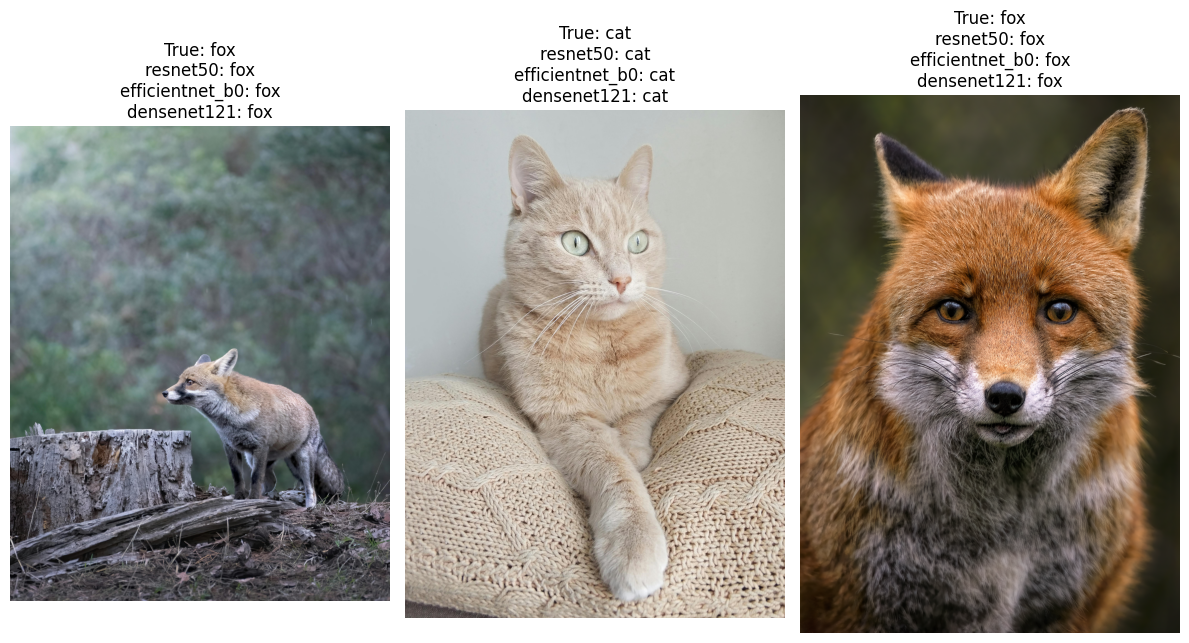

In [81]:
def load_model(model_name, num_classes, device):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    
    # Set weights_only=True to avoid any potential security risks
    model.load_state_dict(torch.load(f'{model_name}_best.pth', weights_only=True))  # Load only model weights
    
    model = model.to(device)
    model.eval()
    return model


transform = T.Compose([ 
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to get the label name from index
def get_class_name(idx, classes):
    return [key for key, value in classes.items() if value == idx][0]

# Load the dataset (make sure the root path is correct)
root_dir = "/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes"
dataset = CustomDataset(root_dir, transform=transform)

# Define the models to load (replace with your actual model names)
model_names = ['resnet50', 'efficientnet_b0', 'densenet121']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
models = {model_name: load_model(model_name, num_classes=3, device=device) for model_name in model_names}

# Pick 3 random images from the dataset
random_images = random.sample(dataset.image_paths, 3)

# Prepare the plot for visualization
plt.figure(figsize=(12, 8))

# Loop through the random images and make predictions
for idx, image_path in enumerate(random_images):
    # Load the image and true label
    image = Image.open(image_path).convert('RGB')
    true_label_idx = dataset.classes[image_path.split('/')[-2]]
    true_label = get_class_name(true_label_idx, dataset.classes)
    
    # Apply the transformation to the image
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Make predictions with each model
    predictions = {}
    with torch.no_grad():
        for model_name, model in models.items():
            output = model(input_image)
            _, predicted_class = torch.max(output, 1)
            predicted_label = get_class_name(predicted_class.item(), dataset.classes)
            predictions[model_name] = predicted_label
    
    # Plot the image with true and predicted labels
    plt.subplot(1, 3, idx + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\n" +
              "\n".join([f"{model_name}: {pred}" for model_name, pred in predictions.items()]))
    plt.axis('off')

plt.tight_layout()
plt.show()

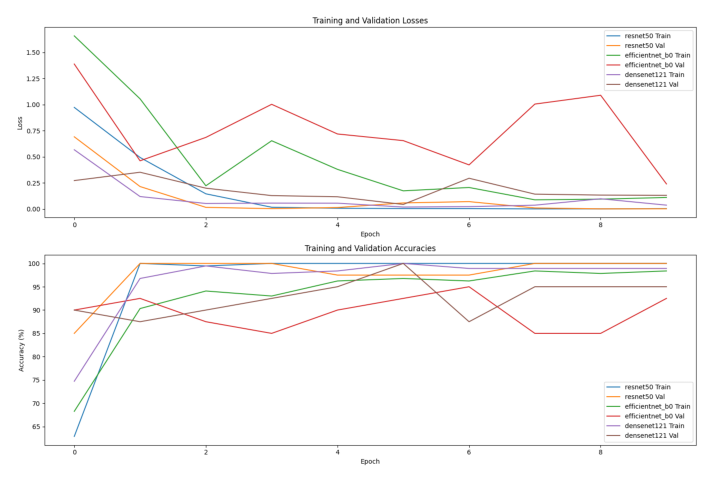

In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the saved training curves plot
img = mpimg.imread('/kaggle/working/training_curves.png')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')  # Hide the axes for a cleaner display
plt.show()

esNet50:

Achieves consistently low training loss and validation loss after the first few epochs, stabilizing well.
Shows high validation accuracy, quickly reaching near 100% by epoch 2 and maintaining it.
EfficientNet B0:

Has a relatively low and stable training loss.
Reaches high validation accuracy early on and maintains it, but not as high as ResNet50.
DenseNet121:

Training loss decreases and stabilizes quickly, but validation loss fluctuates more than ResNet50 and EfficientNet B0.
Validation accuracy is fairly stable and high but slightly lower than ResNet50 and EfficientNet B0.
DenseNet211:

Shows the highest fluctuation in validation loss, suggesting potential instability or overfitting issues.
Validation accuracy is the lowest and varies significantly, indicating it may not generalize as well as the other models.

ResNet50 and EfficientNet B0 appear to perform best overall, with high validation accuracy and stable loss. DenseNet211 performs the worst, with significant fluctuations in validation loss and accuracy. DenseNet121 falls in between but leans closer to the top performers in stability.